In [152]:
import os
from IPython.display import display, clear_output
from xgboost import XGBRegressor
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, ParameterGrid, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


from statsmodels.tsa.stattools import adfuller, kpss, coint
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.api import ARDL
from statsmodels.tsa.ardl import ardl_select_order
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import random
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import seaborn as sns
import statsmodels.api as sm
plt.style.use('ggplot')
pd.options.display.float_format = '{:.4f}'.format

os.chdir('/Users/askar/Desktop/ВКР/Diploma.-Inflation-model-using-PCA')
os.getcwd()

'/Users/askar/Desktop/ВКР/Diploma.-Inflation-model-using-PCA'

In [153]:
# Дата, которая разделяет тренировочную и тестовую выборки, чтобы делить выборки для всех моделей
train_test_split_date = '2022-06-01'

# импортируем данные и делим их по дате
df = pd.read_csv('final_regional_df/infl_Омская_область.csv')
df['date'] = pd.date_range(start='2014-01-01', periods=len(df), freq='ME')

df_train = df[df['date'] < train_test_split_date].copy()
df_test = df[df['date'] >= train_test_split_date].copy()

# Делим Датафреймы на эндогенные и экзогенные переменные
y_train = df_train['inflation']
y_test = df_test['inflation']
df_train.drop(['inflation', 'date'], axis=1, inplace=True)
df_test.drop(['inflation', 'date'], axis=1, inplace=True)
X_train = df_train.copy()
X_test = df_test.copy()

dummies_train = pd.DataFrame(0, index=y_train.index, columns=[
                             'outlier_12', 'outlier_98'])
dummies_test = pd.DataFrame(0, index=y_test.index, columns=[
                            'outlier_12', 'outlier_98'])
dummies_train.iloc[12, 0] = 1  # Дамми для индекса 12
dummies_train.iloc[98, 1] = 1  # Дамми для индекса 98

# Добавляем дамми-переменные к экзогенным факторам
X_train = pd.concat([X_train, dummies_train], axis=1)
X_test = pd.concat([X_test, dummies_test], axis=1)

In [154]:
ardl_df = pd.DataFrame()

res = ARDL(
    y_train,
    1,
    X_train,
    1,
    trend='n'
).fit()
ardl_df = pd.concat([res.params, res.pvalues], axis=1)
ardl_df.columns = ['coef', 'p-value']
ardl_df.drop(['p-value', 'coef'], axis=1, inplace=True)
ardl_df_0 = ardl_df.copy()
ardl_df_05 = ardl_df.copy()
ardl_df_1 = ardl_df.copy()

## ARDL


In [155]:
# Дата, которая разделяет тренировочную и тестовую выборки, чтобы делить выборки для всех моделей
train_test_split_date = '2022-06-01'
file_names = os.listdir('/Users/askar/Desktop/ВКР/Diploma.-Inflation-model-using-PCA/final_regional_df')
source_path = os.path.join(os.getcwd(), 'final_regional_df')
resss=[]

def add_stars(row):
    coef = row['coef']
    pval = row['p-value']
    if pval < 0.01:
        return f"{coef:.2f}***"
    elif pval < 0.05:
        return f"{coef:.2f}**"
    elif pval < 0.1:
        return f"{coef:.2f}*"
    else:
        return f"{coef:.2f}"


def get_max_lags_dict(df_result, p_value_threshold=0.05):
    df = df_result.copy()
    # Получаем уникальные регрессоры (исключая 'inflation')
    regressors = [col for col in df['regr'].unique() if col != 'inflation']
    # Создаем словарь с максимальными лагами только для значимых коэффициентов (p-value <= 0.05)
    max_lags_dict = {}
    for regr in regressors:
        # Находим значимые строки для текущего регрессора (p-value <= 0.05)
        regr_data = df[(df['regr'] == regr) & (df['p-value'] <= 0.05)]
        if not regr_data.empty:
            # Берем максимальный значимый лаг
            max_lag = regr_data['lag'].max()
        else:
            # Если нет значимых коэффициентов, ставим 0
            max_lag = 0
        max_lags_dict[regr] = max_lag

    # Добавляем регрессоры, которых нет в данных, но которые нужны в словаре
    required_regressors = X_train.columns
    for regr in required_regressors:
        if regr not in max_lags_dict:
            max_lags_dict[regr] = 0

    max_lags_dict = {k: max_lags_dict[k] for k in max_lags_dict}
    max_lags_dict = {k: int(v) if isinstance(
        v, str) else v for k, v in sorted(max_lags_dict.items())}

    return max_lags_dict


for file_name in tqdm(file_names):
    df = pd.read_csv(f'{os.path.join(source_path, file_name)}').reset_index(
        drop=True).dropna()
    df['date'] = pd.date_range(start='2014-01-01', periods=len(df), freq='ME')
    df_train = df[df['date'] < train_test_split_date].copy()
    df_test = df[df['date'] >= train_test_split_date].copy()

    # Делим Датафреймы на эндогенные и экзогенные переменные
    y_train = df_train['inflation'].copy() * 100
    y_test = df_test['inflation'].copy() * 100
    df_train.drop(['inflation', 'date'], axis=1, inplace=True)
    df_test.drop(['inflation', 'date'], axis=1, inplace=True)
    X_train = df_train.copy()
    X_test = df_test.copy()

    dummies_train = pd.DataFrame(0, index=y_train.index, columns=['outlier_12', 'outlier_98'])
    dummies_test = pd.DataFrame(0, index=y_test.index, columns=['outlier_12', 'outlier_98'])
    dummies_train.iloc[12, 0] = 1  # Дамми для индекса 12
    dummies_train.iloc[98, 1] = 1  # Дамми для индекса 98

    # Добавляем дамми-переменные к экзогенным факторам
    X_train = pd.concat([X_train, dummies_train], axis=1)
    X_test = pd.concat([X_test, dummies_test], axis=1)

    res = ARDL(y_train, 1, X_train, order=1, trend='n').fit()
    df_result_region = pd.concat([res.params, res.pvalues], axis=1).reset_index()
    df_result_region.columns = ['regr', 'coef', 'p-value']
    df_result_region['lag'] = df_result_region['regr'].apply(lambda x: re.findall(r'[0-9]', x)[-1])
    df_result_region['regr'] = df_result_region['regr'].apply(lambda x: re.sub(r'.L\d+', '', x))
    df_result_region = df_result_region.loc[df_result_region['p-value'] < 0.2]

    res = ARDL(
        y_train,
        1,
        X_train,
        get_max_lags_dict(df_result_region),
        trend='n'
    ).fit()
    result = pd.concat([res.params, res.pvalues], axis=1)
    result.columns = ['coef', 'p-value']
    result[f'{file_name[5:-4]}'] = result[result['p-value'] < 0.1]['coef']
    result.drop(['p-value', 'coef'], axis=1, inplace=True)
    ardl_df_0 = pd.merge(ardl_df_0, result, left_index=True, right_index=True, how='left')

ardl_df_0

100%|██████████| 78/78 [00:00<00:00, 126.61it/s]


Алтайский_край  Волгоградская_область  Амурская_область  \
inflation.L1               0.5356                 1.0019            1.0028   
fm_ibk.L0                 -0.0199                -0.0082           -0.0210   
fm_ibk.L1                  0.0161                    NaN               NaN   
Brent.L0                   0.0118                    NaN            0.0124   
Brent.L1                      NaN                    NaN               NaN   
MIACR.L0                   0.5542                 0.5582            0.4032   
MIACR.L1                  -0.4808                -0.5064           -0.3782   
Infl_exp.L0                   NaN                -0.0478               NaN   
Infl_exp.L1                   NaN                    NaN               NaN   
obligates.L0              -0.1051                -0.1136           -0.1077   
obligates.L1                  NaN                    NaN               NaN   
M2.L0                     10.9169                    NaN           10.6246   
M2.L1                         NaN                    NaN               NaN   
money_income.L0               NaN                 6.4465               NaN   
money_income.L1               NaN                    NaN               NaN   
trade_turnover.L0          3.1575                    NaN               NaN   
trade_turnover.L1             NaN                 4.0462               NaN   
debt_firms.L0                 NaN                    NaN               NaN   
debt_firms.L1                 NaN                    NaN               NaN   
PCA_1.L0                  -0.0404                -0.0738           -0.0503   
PCA_1.L1                      NaN                    NaN               NaN   
PCA_2.L0                      NaN                 0.1098            0.0460   
PCA_2.L1                      NaN                    NaN               NaN   
PCA_3.L0                      NaN                -0.0747           -0.0837   
PCA_3.L1                      NaN                    NaN               NaN   
PCA_4.L0                      NaN                -0.1358               NaN   
PCA_4.L1                      NaN                    NaN               NaN   
PCA_5.L0                   0.0963                    NaN               NaN   
PCA_5.L1                      NaN                    NaN            0.1201   
PCA_6.L0                   0.1876                    NaN           -0.0864   
PCA_6.L1                   0.1255                    NaN               NaN   
outlier_12.L0              1.2713                -0.8877           -1.2178   
outlier_12.L1                 NaN                -2.1990               NaN   
outlier_98.L0                 NaN                -6.2063           -5.0658   
outlier_98.L1                 NaN                    NaN               NaN   

                   Еврейская_автономная_область  г._Санкт-Петербург  \
inflation.L1                             0.9965              1.0019   
fm_ibk.L0                                   NaN             -0.0145   
fm_ibk.L1                                   NaN                 NaN   
Brent.L0                                 0.0124                 NaN   
Brent.L1                                    NaN              0.0153   
MIACR.L0                                 0.5474              0.5657   
MIACR.L1                                -0.5261             -0.5223   
Infl_exp.L0                                 NaN             -0.0439   
Infl_exp.L1                              0.0818                 NaN   
obligates.L0                                NaN                 NaN   
obligates.L1                            -0.1970                 NaN   
M2.L0                                   17.0669                 NaN   
M2.L1                                       NaN                 NaN   
money_income.L0                             NaN                 NaN   
money_income.L1                             NaN                 NaN   
trade_turnover.L0                           NaN                 NaN   
tra

In [156]:
# Дата, которая разделяет тренировочную и тестовую выборки, чтобы делить выборки для всех моделей
train_test_split_date = '2022-06-01'
file_names = os.listdir('/Users/askar/Desktop/ВКР/Diploma.-Inflation-model-using-PCA/final_regional_df')
source_path = os.path.join(os.getcwd(), 'final_regional_df')
resss=[]

def add_stars(row):
    coef = row['coef']
    pval = row['p-value']
    if pval < 0.01:
        return f"{coef:.2f}***"
    elif pval < 0.05:
        return f"{coef:.2f}**"
    elif pval < 0.1:
        return f"{coef:.2f}*"
    else:
        return f"{coef:.2f}"


def get_max_lags_dict(df_result, p_value_threshold=0.05):
    df = df_result.copy()
    # Получаем уникальные регрессоры (исключая 'inflation')
    regressors = [col for col in df['regr'].unique() if col != 'inflation']
    # Создаем словарь с максимальными лагами только для значимых коэффициентов (p-value <= 0.05)
    max_lags_dict = {}
    for regr in regressors:
        # Находим значимые строки для текущего регрессора (p-value <= 0.05)
        regr_data = df[(df['regr'] == regr) & (df['p-value'] <= 0.05)]
        if not regr_data.empty:
            # Берем максимальный значимый лаг
            max_lag = regr_data['lag'].max()
        else:
            # Если нет значимых коэффициентов, ставим 0
            max_lag = 0
        max_lags_dict[regr] = max_lag

    # Добавляем регрессоры, которых нет в данных, но которые нужны в словаре
    required_regressors = X_train.columns
    for regr in required_regressors:
        if regr not in max_lags_dict:
            max_lags_dict[regr] = 0

    max_lags_dict = {k: max_lags_dict[k] for k in max_lags_dict}
    max_lags_dict = {k: int(v) if isinstance(
        v, str) else v for k, v in sorted(max_lags_dict.items())}

    return max_lags_dict


for file_name in tqdm(file_names):
    df = pd.read_csv(f'{os.path.join(source_path, file_name)}').reset_index(
        drop=True).dropna()
    df['date'] = pd.date_range(start='2014-01-01', periods=len(df), freq='ME')
    df_train = df[df['date'] < train_test_split_date].copy()
    df_test = df[df['date'] >= train_test_split_date].copy()

    # Делим Датафреймы на эндогенные и экзогенные переменные
    y_train = df_train['inflation'].copy() * 100
    y_test = df_test['inflation'].copy() * 100
    df_train.drop(['inflation', 'date'], axis=1, inplace=True)
    df_test.drop(['inflation', 'date'], axis=1, inplace=True)
    X_train = df_train.copy()
    X_test = df_test.copy()

    dummies_train = pd.DataFrame(0, index=y_train.index, columns=['outlier_12', 'outlier_98'])
    dummies_test = pd.DataFrame(0, index=y_test.index, columns=['outlier_12', 'outlier_98'])
    dummies_train.iloc[12, 0] = 1  # Дамми для индекса 12
    dummies_train.iloc[98, 1] = 1  # Дамми для индекса 98

    # Добавляем дамми-переменные к экзогенным факторам
    X_train = pd.concat([X_train, dummies_train], axis=1)
    X_test = pd.concat([X_test, dummies_test], axis=1)

    res = ARDL(y_train, 1, X_train, order=1, trend='n').fit()
    df_result_region = pd.concat([res.params, res.pvalues], axis=1).reset_index()
    df_result_region.columns = ['regr', 'coef', 'p-value']
    df_result_region['lag'] = df_result_region['regr'].apply(lambda x: re.findall(r'[0-9]', x)[-1])
    df_result_region['regr'] = df_result_region['regr'].apply(lambda x: re.sub(r'.L\d+', '', x))
    df_result_region = df_result_region.loc[df_result_region['p-value'] < 0.2]

    res = ARDL(
        y_train,
        1,
        X_train,
        get_max_lags_dict(df_result_region),
        trend='n'
    ).fit()
    result = pd.concat([res.params, res.pvalues], axis=1)
    result.columns = ['coef', 'p-value']
    result['coef'] = result.apply(add_stars, axis=1)
    result[f'{file_name[5:-4]}'] = result[result['p-value'] < 0.1]['coef']
    result.drop(['p-value', 'coef'], axis=1, inplace=True)
    ardl_df_05 = pd.merge(ardl_df_05, result, left_index=True, right_index=True, how='left')

ardl_df_05

100%|██████████| 78/78 [00:00<00:00, 117.93it/s]


Алтайский_край Волгоградская_область Амурская_область  \
inflation.L1             0.54***               1.00***          1.00***   
fm_ibk.L0               -0.02***                 -0.01         -0.02***   
fm_ibk.L1                 0.02**                   NaN              NaN   
Brent.L0                   0.01*                   NaN            0.01*   
Brent.L1                     NaN                   NaN              NaN   
MIACR.L0                 0.55***               0.56***          0.40***   
MIACR.L1                -0.48***              -0.51***         -0.38***   
Infl_exp.L0                  NaN                -0.05*              NaN   
Infl_exp.L1                  NaN                   NaN              NaN   
obligates.L0              -0.11*                 -0.11           -0.11*   
obligates.L1                 NaN                   NaN              NaN   
M2.L0                     10.92*                   NaN           10.62*   
M2.L1                        NaN                   NaN              NaN   
money_income.L0              NaN                6.45**              NaN   
money_income.L1              NaN                   NaN              NaN   
trade_turnover.L0        3.16***                   NaN              NaN   
trade_turnover.L1            NaN               4.05***              NaN   
debt_firms.L0                NaN                   NaN              NaN   
debt_firms.L1                NaN                   NaN              NaN   
PCA_1.L0                 -0.04**              -0.07***          -0.05**   
PCA_1.L1                     NaN                   NaN              NaN   
PCA_2.L0                     NaN               0.11***             0.05   
PCA_2.L1                     NaN                   NaN              NaN   
PCA_3.L0                     NaN                 -0.07          -0.08**   
PCA_3.L1                     NaN                   NaN              NaN   
PCA_4.L0                     NaN               -0.14**              NaN   
PCA_4.L1                     NaN                   NaN              NaN   
PCA_5.L0                   0.10*                   NaN              NaN   
PCA_5.L1                     NaN                   NaN           0.12**   
PCA_6.L0                 0.19***                   NaN          -0.09**   
PCA_6.L1                  0.13**                   NaN              NaN   
outlier_12.L0            1.27***                -0.89*         -1.22***   
outlier_12.L1                NaN              -2.20***              NaN   
outlier_98.L0                NaN              -6.21***         -5.07***   
outlier_98.L1                NaN                   NaN              NaN   

                  Еврейская_автономная_область г._Санкт-Петербург  \
inflation.L1                           1.00***            1.00***   
fm_ibk.L0                                  NaN             -0.01*   
fm_ibk.L1                                  NaN                NaN   
Brent.L0                                 0.01*                NaN   
Brent.L1                                   NaN              0.02*   
MIACR.L0                               0.55***            0.57***   
MIACR.L1                              -0.53***           -0.52***   
Infl_exp.L0                                NaN             -0.04*   
Infl_exp.L1                              0.08*                NaN   
obligates.L0                               NaN                NaN   
obligates.L1                          -0.20***                NaN   
M2.L0                                 17.07***                NaN   
M2.L1                                      NaN                NaN   
money_income.L0                            NaN                NaN   
money_income.L1                            NaN                NaN   
trade_turnover.L0                          NaN                NaN   
trade_turnover.L1                          NaN                NaN   
debt_firms.L0                              NaN                NaN   
debt_f

In [157]:
# Дата, которая разделяет тренировочную и тестовую выборки, чтобы делить выборки для всех моделей
train_test_split_date = '2022-06-01'
file_names = os.listdir('/Users/askar/Desktop/ВКР/Diploma.-Inflation-model-using-PCA/final_regional_df')
source_path = os.path.join(os.getcwd(), 'final_regional_df')

def get_max_lags_dict(df_result, p_value_threshold=0.05):
    df = df_result.copy()
    # Получаем уникальные регрессоры (исключая 'inflation')
    regressors = [col for col in df['regr'].unique() if col != 'inflation']
    # Создаем словарь с максимальными лагами только для значимых коэффициентов (p-value <= 0.05)
    max_lags_dict = {}
    for regr in regressors:
        # Находим значимые строки для текущего регрессора (p-value <= 0.05)
        regr_data = df[(df['regr'] == regr) & (df['p-value'] <= 0.05)]
        if not regr_data.empty:
            # Берем максимальный значимый лаг
            max_lag = regr_data['lag'].max()
        else:
            # Если нет значимых коэффициентов, ставим 0
            max_lag = 0
        max_lags_dict[regr] = max_lag

    # Добавляем регрессоры, которых нет в данных, но которые нужны в словаре
    required_regressors = X_train.columns
    for regr in required_regressors:
        if regr not in max_lags_dict:
            max_lags_dict[regr] = 0

    max_lags_dict = {k: max_lags_dict[k] for k in max_lags_dict}
    max_lags_dict = {k: int(v) if isinstance(
        v, str) else v for k, v in sorted(max_lags_dict.items())}

    return max_lags_dict


for file_name in tqdm(file_names):
    df = pd.read_csv(f'{os.path.join(source_path, file_name)}').reset_index(
        drop=True).dropna()
    df['date'] = pd.date_range(start='2014-01-01', periods=len(df), freq='ME')
    df_train = df[df['date'] < train_test_split_date].copy()
    df_test = df[df['date'] >= train_test_split_date].copy()

    # Делим Датафреймы на эндогенные и экзогенные переменные
    y_train = df_train['inflation'].copy() * 100
    y_test = df_test['inflation'].copy() * 100
    df_train.drop(['inflation', 'date'], axis=1, inplace=True)
    df_test.drop(['inflation', 'date'], axis=1, inplace=True)
    X_train = df_train.copy()
    X_test = df_test.copy()

    dummies_train = pd.DataFrame(0, index=y_train.index, columns=['outlier_12', 'outlier_98'])
    dummies_test = pd.DataFrame(0, index=y_test.index, columns=['outlier_12', 'outlier_98'])
    dummies_train.iloc[12, 0] = 1  # Дамми для индекса 12
    dummies_train.iloc[98, 1] = 1  # Дамми для индекса 98

    # Добавляем дамми-переменные к экзогенным факторам
    X_train = pd.concat([X_train, dummies_train], axis=1)
    X_test = pd.concat([X_test, dummies_test], axis=1)

    res = ARDL(y_train, 1, X_train, order=1, trend='n').fit()
    df_result_region = pd.concat([res.params, res.pvalues], axis=1).reset_index()
    df_result_region.columns = ['regr', 'coef', 'p-value']
    df_result_region['lag'] = df_result_region['regr'].apply(lambda x: re.findall(r'[0-9]', x)[-1])
    df_result_region['regr'] = df_result_region['regr'].apply(lambda x: re.sub(r'.L\d+', '', x))
    df_result_region = df_result_region.loc[df_result_region['p-value'] < 0.2]

    res = ARDL(
        y_train,
        1,
        X_train,
        get_max_lags_dict(df_result_region),
        trend='n'
    ).fit()
    result = pd.concat([res.params, res.pvalues], axis=1)
    result.columns = ['coef', 'p-value']
    result[f'{file_name[5:-4]}'] = result['coef']
    result.drop(['p-value', 'coef'], axis=1, inplace=True)
    ardl_df_1 = pd.merge(ardl_df_1, result, left_index=True, right_index=True, how='left')

ardl_df_1

100%|██████████| 78/78 [00:00<00:00, 125.31it/s]


Алтайский_край  Волгоградская_область  Амурская_область  \
inflation.L1               0.5356                 1.0019            1.0028   
fm_ibk.L0                 -0.0199                -0.0082           -0.0210   
fm_ibk.L1                  0.0161                    NaN               NaN   
Brent.L0                   0.0118                -0.0006            0.0124   
Brent.L1                      NaN                    NaN               NaN   
MIACR.L0                   0.5542                 0.5582            0.4032   
MIACR.L1                  -0.4808                -0.5064           -0.3782   
Infl_exp.L0               -0.0227                -0.0478           -0.0381   
Infl_exp.L1                   NaN                    NaN               NaN   
obligates.L0              -0.1051                -0.1136           -0.1077   
obligates.L1                  NaN                    NaN               NaN   
M2.L0                     10.9169                -7.5834           10.6246   
M2.L1                         NaN                    NaN               NaN   
money_income.L0           -0.8198                 6.4465           -1.7012   
money_income.L1               NaN                    NaN               NaN   
trade_turnover.L0          3.1575                 0.9383            0.9795   
trade_turnover.L1             NaN                 4.0462               NaN   
debt_firms.L0             -0.6077                 1.4792           -1.0150   
debt_firms.L1                 NaN                    NaN               NaN   
PCA_1.L0                  -0.0404                -0.0738           -0.0503   
PCA_1.L1                      NaN                    NaN               NaN   
PCA_2.L0                  -0.0094                 0.1098            0.0460   
PCA_2.L1                      NaN                    NaN               NaN   
PCA_3.L0                  -0.0203                -0.0747           -0.0837   
PCA_3.L1                      NaN                    NaN               NaN   
PCA_4.L0                   0.0644                -0.1358            0.0228   
PCA_4.L1                      NaN                    NaN               NaN   
PCA_5.L0                   0.0963                 0.0268           -0.0342   
PCA_5.L1                      NaN                    NaN            0.1201   
PCA_6.L0                   0.1876                -0.0490           -0.0864   
PCA_6.L1                   0.1255                    NaN               NaN   
outlier_12.L0              1.2713                -0.8877           -1.2178   
outlier_12.L1                 NaN                -2.1990               NaN   
outlier_98.L0             -0.7762                -6.2063           -5.0658   
outlier_98.L1                 NaN                    NaN               NaN   

                   Еврейская_автономная_область  г._Санкт-Петербург  \
inflation.L1                             0.9965              1.0019   
fm_ibk.L0                                0.0072             -0.0145   
fm_ibk.L1                                   NaN                 NaN   
Brent.L0                                 0.0124              0.0014   
Brent.L1                                    NaN              0.0153   
MIACR.L0                                 0.5474              0.5657   
MIACR.L1                                -0.5261             -0.5223   
Infl_exp.L0                             -0.0662             -0.0439   
Infl_exp.L1                              0.0818                 NaN   
obligates.L0                            -0.0092             -0.0487   
obligates.L1                            -0.1970                 NaN   
M2.L0                                   17.0669              3.2099   
M2.L1                                       NaN                 NaN   
money_income.L0                         -0.7584             -1.3955   
money_income.L1                             NaN                 NaN   
trade_turnover.L0                        1.4255              1.1593   
tra

In [79]:
df_5 = ardl_df_05.T.describe()
df_5.drop(['fm_ibk.L0', 'fm_ibk.L1', 'Brent.L1', 'MIACR.L1', 'Infl_exp.L1', 'money_income.L1', 'M2.L1', 'PCA_1.L1', 'PCA_2.L1', 'PCA_3.L1', 'obligates.L1',
           'PCA_4.L1', 'PCA_5.L1', 'PCA_6.L1', 'outlier_12.L0', 'outlier_12.L1', 'debt_firms.L1', 'trade_turnover.L1'], axis=1, inplace=True)
df_5.T

count    mean    std     min     25%     50%     75%  \
inflation.L1      78.0000  0.8756 0.2140  0.2240  0.8197  0.9983  1.0011   
Brent.L0          30.0000  0.0185 0.0056  0.0118  0.0127  0.0173  0.0233   
MIACR.L0          78.0000  0.5438 0.1403 -0.1860  0.4991  0.5576  0.6233   
Infl_exp.L0       37.0000 -0.0509 0.1055 -0.1921 -0.0781 -0.0649 -0.0477   
obligates.L0      41.0000 -0.1289 0.1262 -0.2628 -0.1911 -0.1636 -0.1136   
M2.L0             38.0000 16.5887 5.4941  8.2920 12.4839 15.3353 19.5420   
money_income.L0   13.0000  4.8423 2.3673 -1.3684  4.4047  5.4767  6.2139   
trade_turnover.L0 24.0000  2.3642 2.0343 -5.8103  1.5830  2.8653  3.2558   
debt_firms.L0     17.0000  1.1531 2.9110 -5.3535 -0.5409  1.7100  2.5087   
PCA_1.L0          42.0000 -0.0429 0.0450 -0.0943 -0.0711 -0.0518 -0.0403   
PCA_2.L0          36.0000  0.0131 0.1004 -0.1638 -0.0810  0.0518  0.0950   
PCA_3.L0          30.0000  0.0319 0.1086 -0.1946 -0.0714  0.0690  0.1050   
PCA_4.L0          29.0000  0.0006 0.1565 -0.3282 -0.1188 -0.0973  0.1249   
PCA_5.L0          25.0000  0.0023 0.1450 -0.3527 -0.1185  0.0955  0.1082   
PCA_6.L0          23.0000 -0.0201 0.1498 -0.2296 -0.1560 -0.0864  0.1228   
outlier_98.L0     67.0000 -5.2829 1.8339 -8.4558 -6.4156 -5.4158 -3.9735   
outlier_98.L1      7.0000  1.8775 0.4717  1.2917  1.5697  1.8859  2.0861   

                      max  
inflation.L1       1.0723  
Brent.L0           0.0299  
MIACR.L0           0.7929  
Infl_exp.L0        0.5111  
obligates.L0       0.3201  
M2.L0             31.7079  
money_income.L0    7.7113  
trade_turnover.L0  4.7123  
debt_firms.L0      5.8743  
PCA_1.L0           0.0709  
PCA_2.L0           0.1689  
PCA_3.L0           0.2208  
PCA_4.L0           0.2548  
PCA_5.L0           0.2069  
PCA_6.L0           0.2281  
outlier_98.L0     -1.0265  
outlier_98.L1      2.6533

In [136]:
rows = 13
cols = 5
fig, axes = plt.subplots(rows, cols, figsize=(120, 120), dpi=100)
mseee = []
rmseee = []
mapeee = []
for i in range(len(file_names)):
    try:
        row = i // cols
        col = i % cols
        df = pd.read_csv(f'{os.path.join(source_path, file_names[i])}').reset_index(
            drop=True).dropna()
        df['date'] = pd.date_range(start='2014-01-01', periods=len(df), freq='ME')
        df.drop(['fm_ibk', 'PCA_1', 'PCA_2', 'PCA_3'], axis=1, inplace=True)
        df_train = df[df['date'] < train_test_split_date].copy()
        df_test = df[df['date'] >= train_test_split_date].copy()
        # Делим Датафреймы на эндогенные и экзогенные переменные
        y_train = df_train['inflation'].copy() * 100
        y_test = df_test['inflation'].copy() * 100
        df_train.drop(['inflation', 'date'], axis=1, inplace=True)
        df_test.drop(['inflation', 'date'], axis=1, inplace=True)
        X_train = df_train.copy()
        X_test = df_test.copy()

        dummies_train = pd.DataFrame(0, index=y_train.index, columns=['outlier_12', 'outlier_98'])
        dummies_test = pd.DataFrame(0, index=y_test.index, columns=['outlier_12', 'outlier_98'])
        dummies_train.iloc[12, 0] = 1  # Дамми для индекса 12
        dummies_train.iloc[98, 1] = 1  # Дамми для индекса 98

        # Добавляем дамми-переменные к экзогенным факторам
        X_train = pd.concat([X_train, dummies_train], axis=1)
        X_test = pd.concat([X_test, dummies_test], axis=1)

        res = ARDL(y_train, 1, X_train, order=1, trend='n').fit()
        df_result_region = pd.concat([res.params, res.pvalues], axis=1).reset_index()
        df_result_region.columns = ['regr', 'coef', 'p-value']
        df_result_region['lag'] = df_result_region['regr'].apply(lambda x: re.findall(r'[0-9]', x)[-1])
        df_result_region['regr'] = df_result_region['regr'].apply(lambda x: re.sub(r'.L\d+', '', x))
        df_result_region = df_result_region.loc[df_result_region['p-value'] < 0.2]

        res = ARDL(
            y_train,
            1,
            X_train,
            get_max_lags_dict(df_result_region),
            trend='n'
        ).fit()

        forecast = res.forecast(steps=len(y_test), exog=X_test[:len(y_test)])
        mse = mean_squared_error(y_test, forecast)
        rmse = np.sqrt(mean_squared_error(y_test, forecast))
        mape = mean_absolute_percentage_error(y_test, forecast)
        mseee.append(mse)
        rmseee.append(rmse)
        mapeee.append(mape)
        axes[row, col].plot(y_test.index, forecast, label='forecast')
        axes[row, col].plot(y_test.index, y_test, label='real')
        axes[row, col].set_xticks(
            np.arange(len(y_train), len(y_train)+len(y_test)+1, 1))
        axes[row, col].set_title(
            f'{file_names[i][5:-4]},    MSE: {round(mse, 4)}', fontsize=24)
        axes[row, col].legend()
    except Exception as e:
        print(f"❌ Error in {file_name}: {str(e)}")
        continue
plt.savefig('result/ARDL_predict.pdf')

❌ Error in infl_Калужская_область.csv: Prediction must have `end` after `start`.
❌ Error in infl_Калужская_область.csv: index 13 is out of bounds for axis 0 with size 13
❌ Error in infl_Калужская_область.csv: index 13 is out of bounds for axis 0 with size 13
❌ Error in infl_Калужская_область.csv: index 13 is out of bounds for axis 0 with size 13
❌ Error in infl_Калужская_область.csv: index 13 is out of bounds for axis 0 with size 13
❌ Error in infl_Калужская_область.csv: index 13 is out of bounds for axis 0 with size 13
❌ Error in infl_Калужская_область.csv: index 14 is out of bounds for axis 0 with size 13
❌ Error in infl_Калужская_область.csv: index 14 is out of bounds for axis 0 with size 13
❌ Error in infl_Калужская_область.csv: index 14 is out of bounds for axis 0 with size 13
❌ Error in infl_Калужская_область.csv: index 14 is out of bounds for axis 0 with size 13
❌ Error in infl_Калужская_область.csv: index 14 is out of bounds for axis 0 with size 13
❌ Error in infl_Калужская_обл

In [140]:
np.min(mseee), np.min(rmseee), np.min(mapeee)

(0.1894732917148138, 0.4352852992174372, 0.003516319211325573)

In [141]:
np.max(mseee), np.max(rmseee), np.max(mapeee)

(39.71755531759985, 6.302186550523545, 0.05386813910449782)

In [142]:
np.median(mseee), np.median(rmseee), np.median(mapeee)

(1.541730897087181, 1.2416645670579398, 0.009277454921618184)

In [143]:
np.mean(mseee), np.mean(rmseee), np.mean(mapeee)

(2.3877073482247546, 1.3483723201566618, 0.010862202219691199)

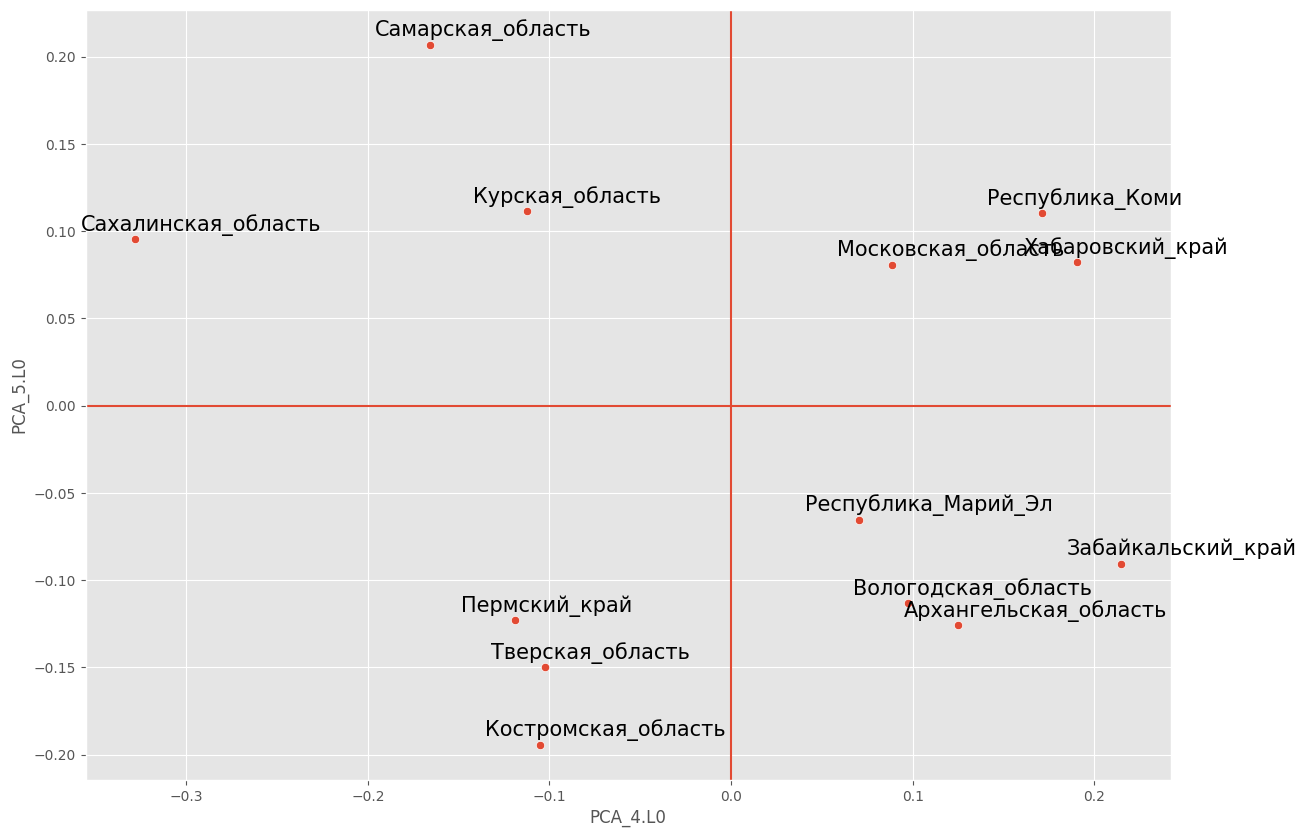

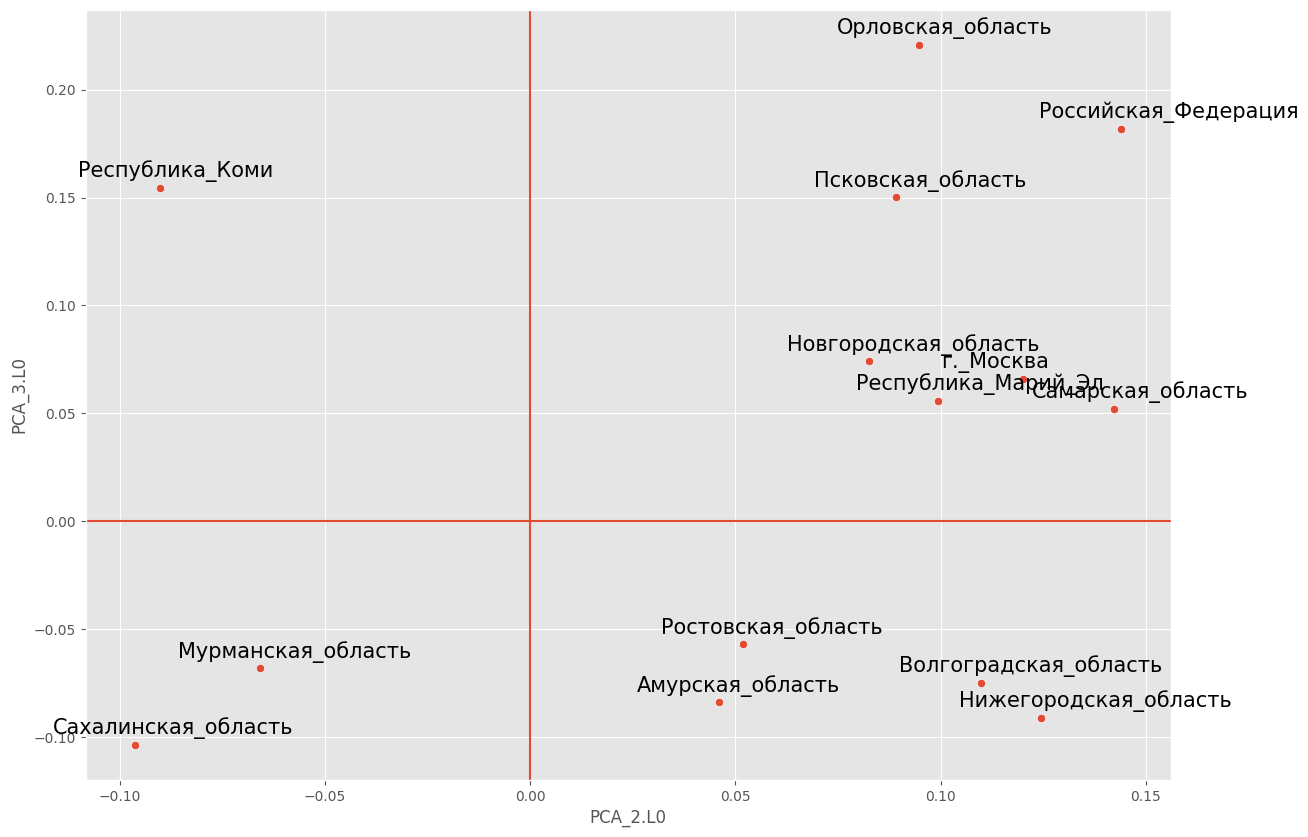

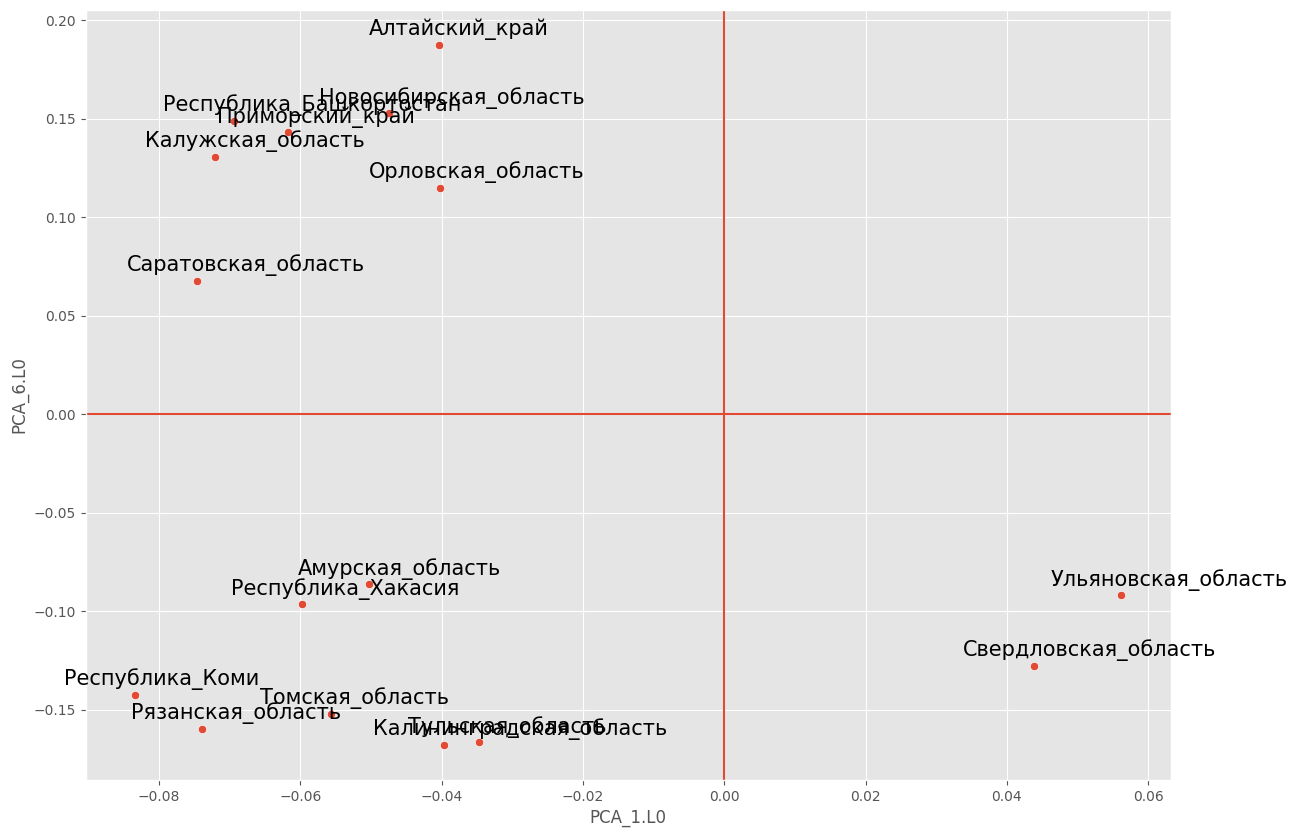

In [71]:
PCA_1 = ardl_df_05.T.loc[:, 'PCA_1.L0'].dropna().to_frame().T
PCA_1_1 = ardl_df_05.T.loc[:, 'PCA_1.L1'].dropna().to_frame().T
PCA_2 = ardl_df_05.T.loc[:, 'PCA_2.L0'].dropna().to_frame().T
PCA_2_1 = ardl_df_05.T.loc[:, 'PCA_2.L1'].dropna().to_frame().T
PCA_3 = ardl_df_05.T.loc[:, 'PCA_3.L0'].dropna().to_frame().T
PCA_3_1 = ardl_df_05.T.loc[:, 'PCA_3.L1'].dropna().to_frame().T
PCA_4 = ardl_df_05.T.loc[:, 'PCA_4.L0'].dropna().to_frame().T
PCA_4_1 = ardl_df_05.T.loc[:, 'PCA_4.L1'].dropna().to_frame().T
PCA_5 = ardl_df_05.T.loc[:, 'PCA_5.L0'].dropna().to_frame().T
PCA_5_1 = ardl_df_05.T.loc[:, 'PCA_5.L1'].dropna().to_frame().T
PCA_6 = ardl_df_05.T.loc[:, 'PCA_6.L0'].dropna().to_frame().T
PCA_6_1 = ardl_df_05.T.loc[:, 'PCA_6.L1'].dropna().to_frame().T

df_1 = pd.concat([PCA_4, PCA_5]).T.dropna()
df_2 = pd.concat([PCA_2, PCA_3]).T.dropna()
df_3 = pd.concat([PCA_1, PCA_6]).T.dropna()

plt.figure(figsize=(14, 10))
sb.scatterplot(df_1, x='PCA_4.L0', y='PCA_5.L0')
for region in df_1.index:
    plt.text(df_1.loc[region, 'PCA_4.L0']-0.03 ,df_1.loc[region, 'PCA_5.L0']+0.005,region, fontsize=15)
plt.axhline(y=0)
plt.axvline(x=0)
plt.show()    

plt.figure(figsize=(14, 10))
sb.scatterplot(df_2, x='PCA_2.L0', y='PCA_3.L0')
for region in df_2.index:
    plt.text(df_2.loc[region, 'PCA_2.L0']-0.02, df_2.loc[region, 'PCA_3.L0']+0.005,region, fontsize=15)
plt.axhline(y=0)
plt.axvline(x=0)
plt.show()

plt.figure(figsize=(14, 10))
sb.scatterplot(df_3, x='PCA_1.L0', y='PCA_6.L0')
for region in df_3.index:
    plt.text(df_3.loc[region, 'PCA_1.L0']-0.01 ,df_3.loc[region, 'PCA_6.L0']+0.005,region, fontsize=15)
plt.axhline(y=0)
plt.axvline(x=0)
plt.show()

In [158]:
with pd.ExcelWriter("Результаты регрессий и МГК/regression_results.xlsx") as writer:
    ardl_df_0.to_excel(writer, sheet_name="Результаты со звездочками", index=True)
    ardl_df_05.to_excel(writer, sheet_name="Результаты только с статзначим", index=True)
    ardl_df_1.to_excel(writer, sheet_name="Результаты без статзначимости", index=True)